In [157]:
import numpy as np
import pandas as pd
import math
from statistics import NormalDist
import plotly.graph_objects as go
import plotly.express as px
from matplotlib import pyplot as plt


for i, day in enumerate([0, 1, 2]):
    file_name = f"./round-3-island-data-bottle/prices_round_3_day_{day}.csv"
    df_tmp = pd.read_csv(file_name, sep=';')
    df_tmp['day'] = day
    if i > 0:
        df = pd.concat([df, df_tmp])
    else:
        df = df_tmp
df = df.reset_index(drop=True)

First estimate the IV vs time with diffent strike, then fit the IV with parabolic function.

In [182]:
class BlackScholes:
    @staticmethod
    def black_scholes_call(spot, strike, time_to_maturity, volatility):
        if volatility == 0:
            return spot - strike
        d1 = (
            math.log(spot) - math.log(strike) + (0.5 * volatility * volatility) * time_to_maturity
        ) / (volatility * math.sqrt(time_to_maturity))
        d2 = d1 - volatility * math.sqrt(time_to_maturity)
        call_price = spot * NormalDist().cdf(d1) - strike * NormalDist().cdf(d2)
        return call_price

    @staticmethod
    def black_scholes_put(spot, strike, time_to_maturity, volatility):
        if volatility == 0:
            return strike - spot
        d1 = (math.log(spot / strike) + (0.5 * volatility * volatility) * time_to_maturity) / (
            volatility * math.sqrt(time_to_maturity)
        )
        d2 = d1 - volatility * math.sqrt(time_to_maturity)
        put_price = strike * NormalDist().cdf(-d2) - spot * NormalDist().cdf(-d1)
        return put_price

    @staticmethod
    def delta(spot, strike, time_to_maturity, volatility):
        if volatility == 0:
            return 1
        d1 = (
            math.log(spot) - math.log(strike) + (0.5 * volatility * volatility) * time_to_maturity
        ) / (volatility * math.sqrt(time_to_maturity))
        return NormalDist().cdf(d1)

    @staticmethod
    def gamma(spot, strike, time_to_maturity, volatility):
        if volatility == 0:
            return 0
        d1 = (
            math.log(spot) - math.log(strike) + (0.5 * volatility * volatility) * time_to_maturity
        ) / (volatility * math.sqrt(time_to_maturity))
        return NormalDist().pdf(d1) / (spot * volatility * math.sqrt(time_to_maturity))

    @staticmethod
    def vega(spot, strike, time_to_maturity, volatility):
        if volatility == 0:
            return 0
        d1 = (
            math.log(spot) - math.log(strike) + (0.5 * volatility * volatility) * time_to_maturity
        ) / (volatility * math.sqrt(time_to_maturity))
        # print(f"d1: {d1}")
        # print(f"vol: {volatility}")
        # print(f"spot: {spot}")
        # print(f"strike: {strike}")
        # print(f"time: {time_to_maturity}")
        return NormalDist().pdf(d1) * (spot * math.sqrt(time_to_maturity)) / 100

    @staticmethod
    def implied_volatility(
        call_price, spot, strike, time_to_maturity, max_iterations=100, tolerance=1e-5, learning_rate=1
    ):
        if call_price < spot - strike:
            return 0

        # Initial guess for volatility
        volatility = 0.13  # Start with a reasonable guess
        for _ in range(max_iterations):
            d1 = (
            math.log(spot) - math.log(strike) + (0.5 * volatility * volatility) * time_to_maturity
        ) / (volatility * math.sqrt(time_to_maturity))
            d2 = d1 - volatility * math.sqrt(time_to_maturity)
            estimated_price = spot * NormalDist().cdf(d1) - strike * NormalDist().cdf(d2)
            vega = NormalDist().pdf(d1) * (spot * math.sqrt(time_to_maturity))

            # If vega is too small, the gradient descent may not converge
            if vega < 1e-10:
                print("vega instable")
                return np.nan

            # Update volatility using gradient descent
            diff = estimated_price - call_price
            volatility -= learning_rate * diff / vega

            # Check for convergence
            if abs(diff) < tolerance:
                return volatility
        print("max_iter reached")
        return np.nan
    

In [43]:
STRIKES = [9500, 9750, 10000, 10250, 10500]
TIME_TO_MATURITY = 8

In [44]:
df = df[df['product'].str.startswith('VOLCANIC_ROCK')].copy().reset_index(drop=True)
df.head()

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,0,0,VOLCANIC_ROCK_VOUCHER_10500,99.0,19.0,NaN,NaN,NaN,NaN,100,19,NaN,NaN,NaN,NaN,99.5,0.0
1,0,0,VOLCANIC_ROCK_VOUCHER_10000,505.0,19.0,NaN,NaN,NaN,NaN,506,19,NaN,NaN,NaN,NaN,505.5,0.0
2,0,0,VOLCANIC_ROCK_VOUCHER_9750,754.0,19.0,NaN,NaN,NaN,NaN,755,19,NaN,NaN,NaN,NaN,754.5,0.0
3,0,0,VOLCANIC_ROCK_VOUCHER_9500,1003.0,19.0,NaN,NaN,NaN,NaN,1004,19,NaN,NaN,NaN,NaN,1003.5,0.0
4,0,0,VOLCANIC_ROCK_VOUCHER_10250,273.0,19.0,NaN,NaN,NaN,NaN,274,19,NaN,NaN,NaN,NaN,273.5,0.0


In [45]:
spot = df[df['product'] == 'VOLCANIC_ROCK'].copy().reset_index(drop=True)
spot.to_csv(f'./option_data/VOLCANIC_ROCK.csv', sep=';', index=False)
for strike in STRIKES:
    # Obtain the implied volatility with BS
    option = df[df['product'] == f'VOLCANIC_ROCK_VOUCHER_{strike}'].copy().reset_index(drop=True)
    option['implied_volatility'] = option.apply(
        lambda x: BlackScholes.implied_volatility(
            x['mid_price'],
            spot[(spot['timestamp'] == x['timestamp']) & (spot['day'] == x['day'])]['mid_price'].values[0],
            strike,
            (TIME_TO_MATURITY - x['day'] - x['timestamp'] / 1000000) / 250,
        ),
        axis=1,
    )
    
    print(f"Average IV for strike price {strike}: {option['implied_volatility'].mean()}")
    print(f"Std of IV for strike price {strike}: {option['implied_volatility'].std()}")
    option['delta'] = option.apply(
        lambda x: BlackScholes.delta(
            spot[(spot['timestamp'] == x['timestamp']) & (spot['day'] == x['day'])]['mid_price'].values[0],
            strike,
            (TIME_TO_MATURITY - x['day'] - x['timestamp'] / 1000000) / 250,
            x['implied_volatility'],
        ),
        axis=1,
    )
    option['gamma'] = option.apply(
        lambda x: BlackScholes.gamma(
            spot[(spot['timestamp'] == x['timestamp']) & (spot['day'] == x['day'])]['mid_price'].values[0],
            strike,
            (TIME_TO_MATURITY - x['day'] - x['timestamp'] / 1000000) / 250,
            x['implied_volatility'],
        ),
        axis=1,
    )
    option['vega'] = option.apply(
        lambda x: BlackScholes.vega(
            spot[(spot['timestamp'] == x['timestamp']) & (spot['day'] == x['day'])]['mid_price'].values[0],
            strike,
            (TIME_TO_MATURITY - x['day'] - x['timestamp'] / 1000000) / 250,
            x['implied_volatility'],
        ),
        axis=1,
    )
    option.to_csv(f'./option_data/VOLCANIC_ROCK_VOUCHER_{strike}.csv', sep=';', index=False)

Average IV for strike price 9500: 0.1414295741473993
Std of IV for strike price 9500: 0.07014497448594298
Average IV for strike price 9750: 0.14950641190297997
Std of IV for strike price 9750: 0.02884108202940475
Average IV for strike price 10000: 0.13574459922820925
Std of IV for strike price 10000: 0.00867501237030994
Average IV for strike price 10250: 0.12708601445472986
Std of IV for strike price 10250: 0.002823187460884323
Average IV for strike price 10500: 0.129645771725291
Std of IV for strike price 10500: 0.00560307081505544


In [183]:
spot = df[df['product'] == 'VOLCANIC_ROCK'].copy().reset_index(drop=True)
strike = 9500
# Obtain the implied volatility with BS
option = df[df['product'] == f'VOLCANIC_ROCK_VOUCHER_{strike}'].copy().reset_index(drop=True)
option['implied_volatility'] = option.apply(
    lambda x: BlackScholes.implied_volatility(
        x['mid_price'],
        spot[(spot['timestamp'] == x['timestamp']) & (spot['day'] == x['day'])]['mid_price'].values[0],
        strike,
        (TIME_TO_MATURITY - x['day'] - x['timestamp'] / 1000000) / 250,
    ),
    axis=1,
)

print(f"Average IV for strike price {strike}: {option['implied_volatility'].mean()}")
print(f"Std of IV for strike price {strike}: {option['implied_volatility'].std()}")
option['delta'] = option.apply(
    lambda x: BlackScholes.delta(
        spot[(spot['timestamp'] == x['timestamp']) & (spot['day'] == x['day'])]['mid_price'].values[0],
        strike,
        (TIME_TO_MATURITY - x['day'] - x['timestamp'] / 1000000) / 250,
        x['implied_volatility'],
    ),
    axis=1,
)
option['gamma'] = option.apply(
    lambda x: BlackScholes.gamma(
        spot[(spot['timestamp'] == x['timestamp']) & (spot['day'] == x['day'])]['mid_price'].values[0],
        strike,
        (TIME_TO_MATURITY - x['day'] - x['timestamp'] / 1000000) / 250,
        x['implied_volatility'],
    ),
    axis=1,
)
option['vega'] = option.apply(
    lambda x: BlackScholes.vega(
        spot[(spot['timestamp'] == x['timestamp']) & (spot['day'] == x['day'])]['mid_price'].values[0],
        strike,
        (TIME_TO_MATURITY - x['day'] - x['timestamp'] / 1000000) / 250,
        x['implied_volatility'],
    ),
    axis=1,
)
    # option.to_csv(f'./option_data/VOLCANIC_ROCK_VOUCHER_{strike}.csv', sep=';', index=False)

vega instable
vega instable
vega instable
vega instable
vega instable
vega instable
vega instable
vega instable
vega instable
vega instable
vega instable
vega instable
vega instable
vega instable
vega instable
vega instable
vega instable
vega instable
vega instable
vega instable
vega instable
vega instable
vega instable
vega instable
vega instable
vega instable
vega instable
vega instable
vega instable
vega instable
vega instable
vega instable
vega instable
vega instable
vega instable
vega instable
vega instable
vega instable
vega instable
vega instable
vega instable
vega instable
vega instable
vega instable
vega instable
vega instable
vega instable
vega instable
vega instable
vega instable
vega instable
vega instable
vega instable
vega instable
vega instable
vega instable
vega instable
vega instable
vega instable
vega instable
vega instable
vega instable
vega instable
vega instable
vega instable
vega instable
vega instable
vega instable
vega instable
vega instable
vega instable
vega i

In [176]:
old_option = pd.read_csv(f'./option_data/VOLCANIC_ROCK_VOUCHER_{strike}.csv', sep=';')
(option['implied_volatility'] / old_option['implied_volatility']) - 1

0        7.537283e-07
1       -1.128596e-06
2       -2.453014e-08
3        3.784375e-07
4       -9.274808e-07
             ...     
29995    4.639906e-01
29996   -9.708284e-07
29997   -9.756988e-07
29998    4.635141e-01
29999    4.625252e-01
Name: implied_volatility, Length: 30000, dtype: float64

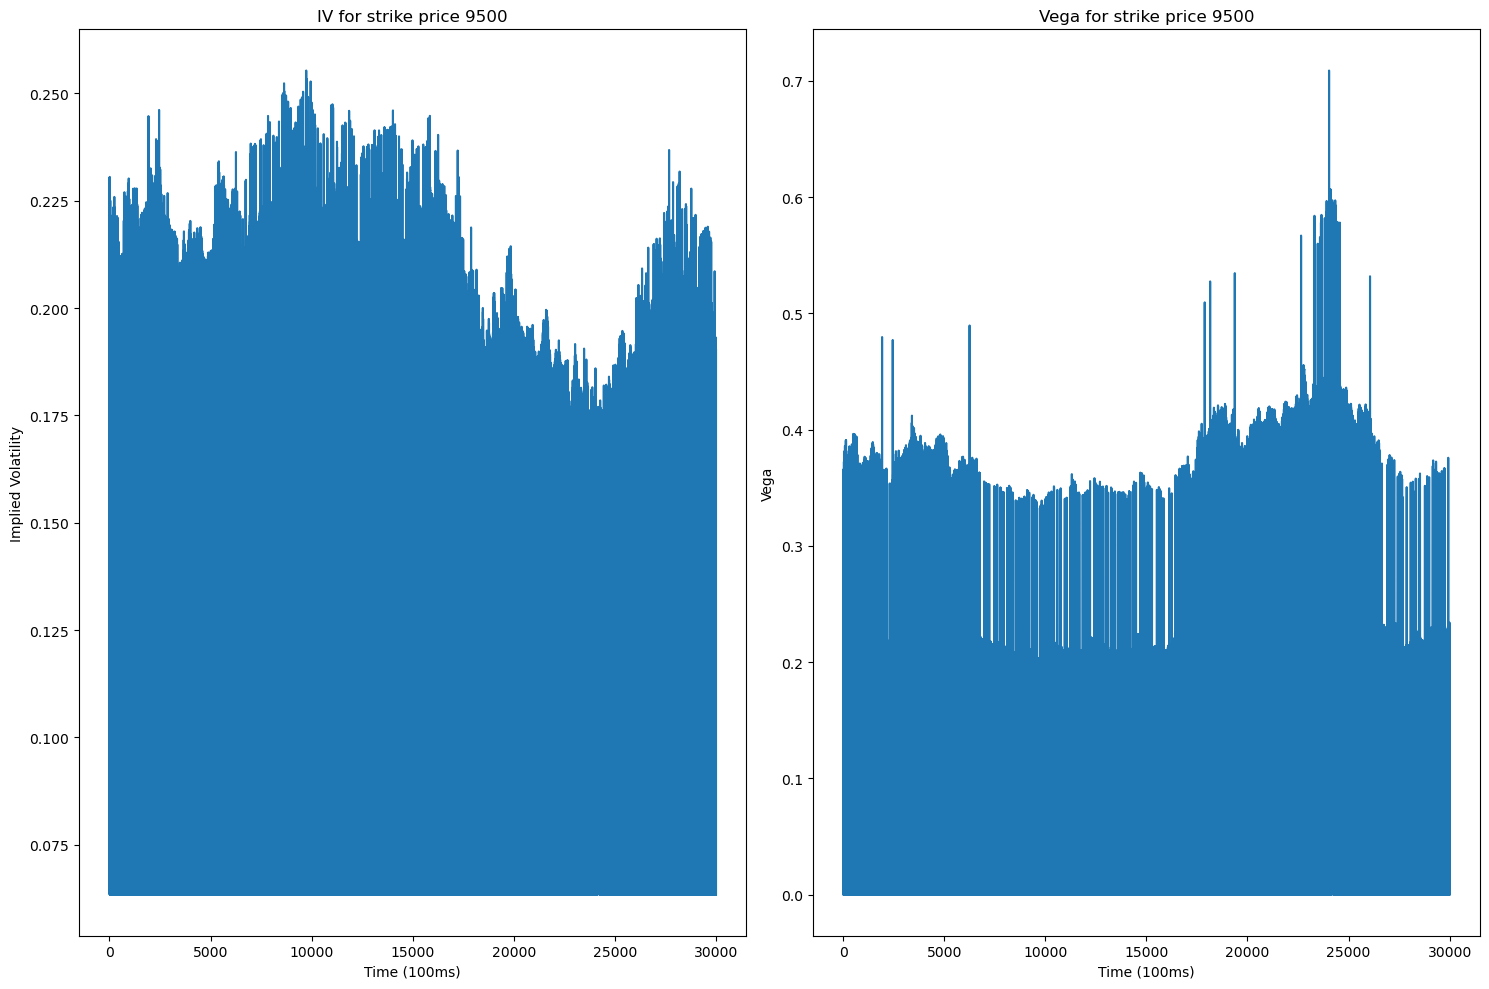

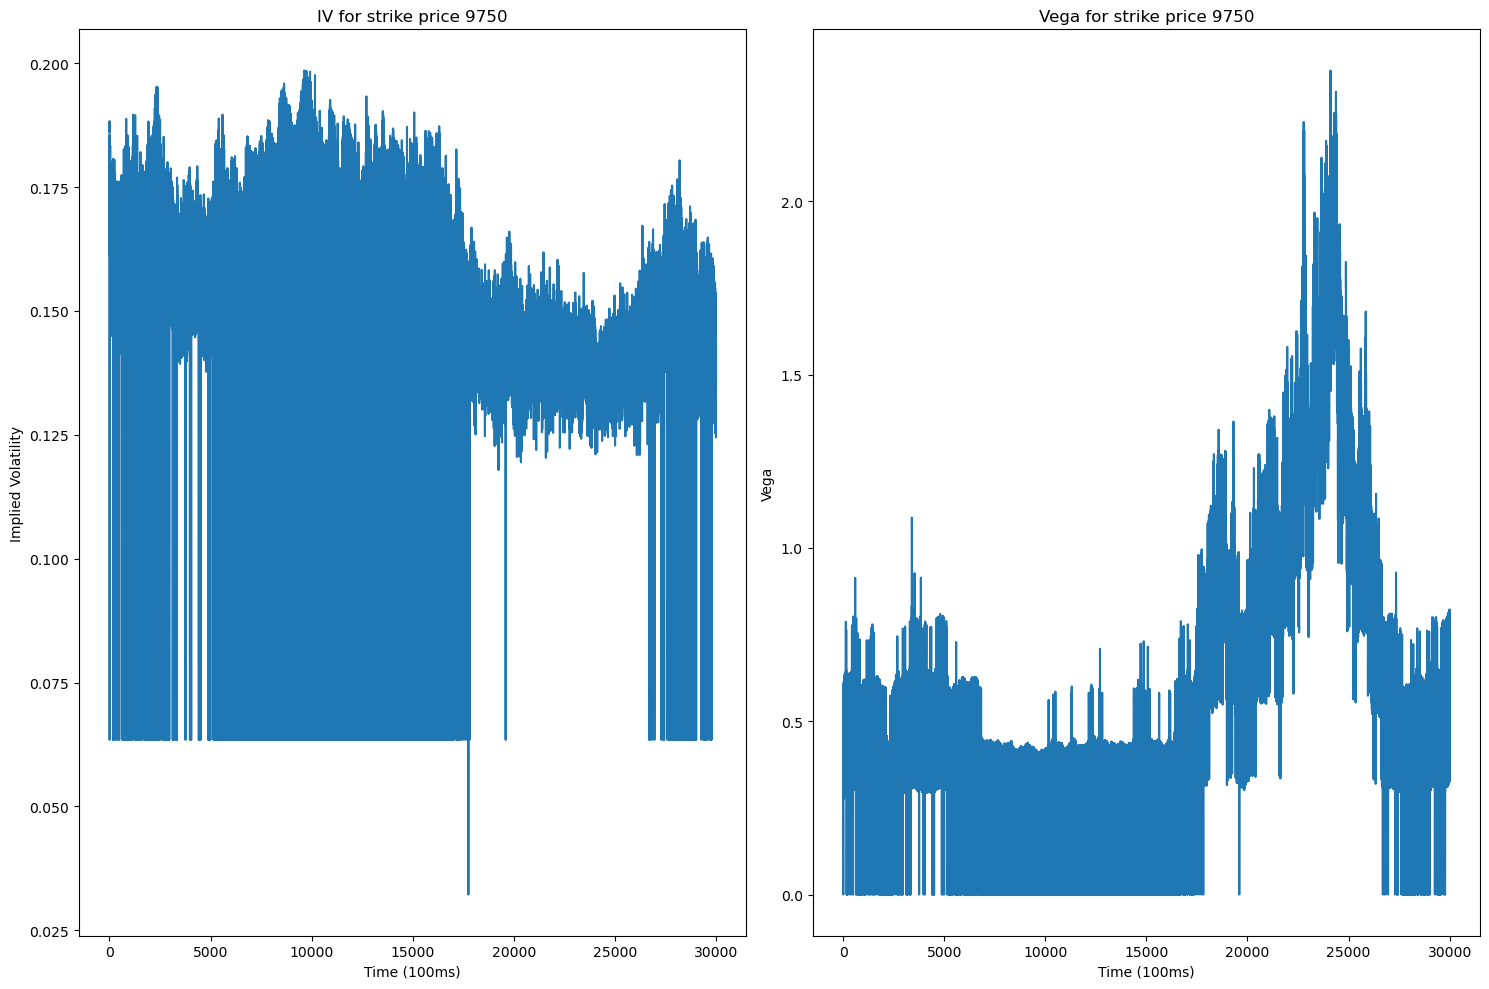

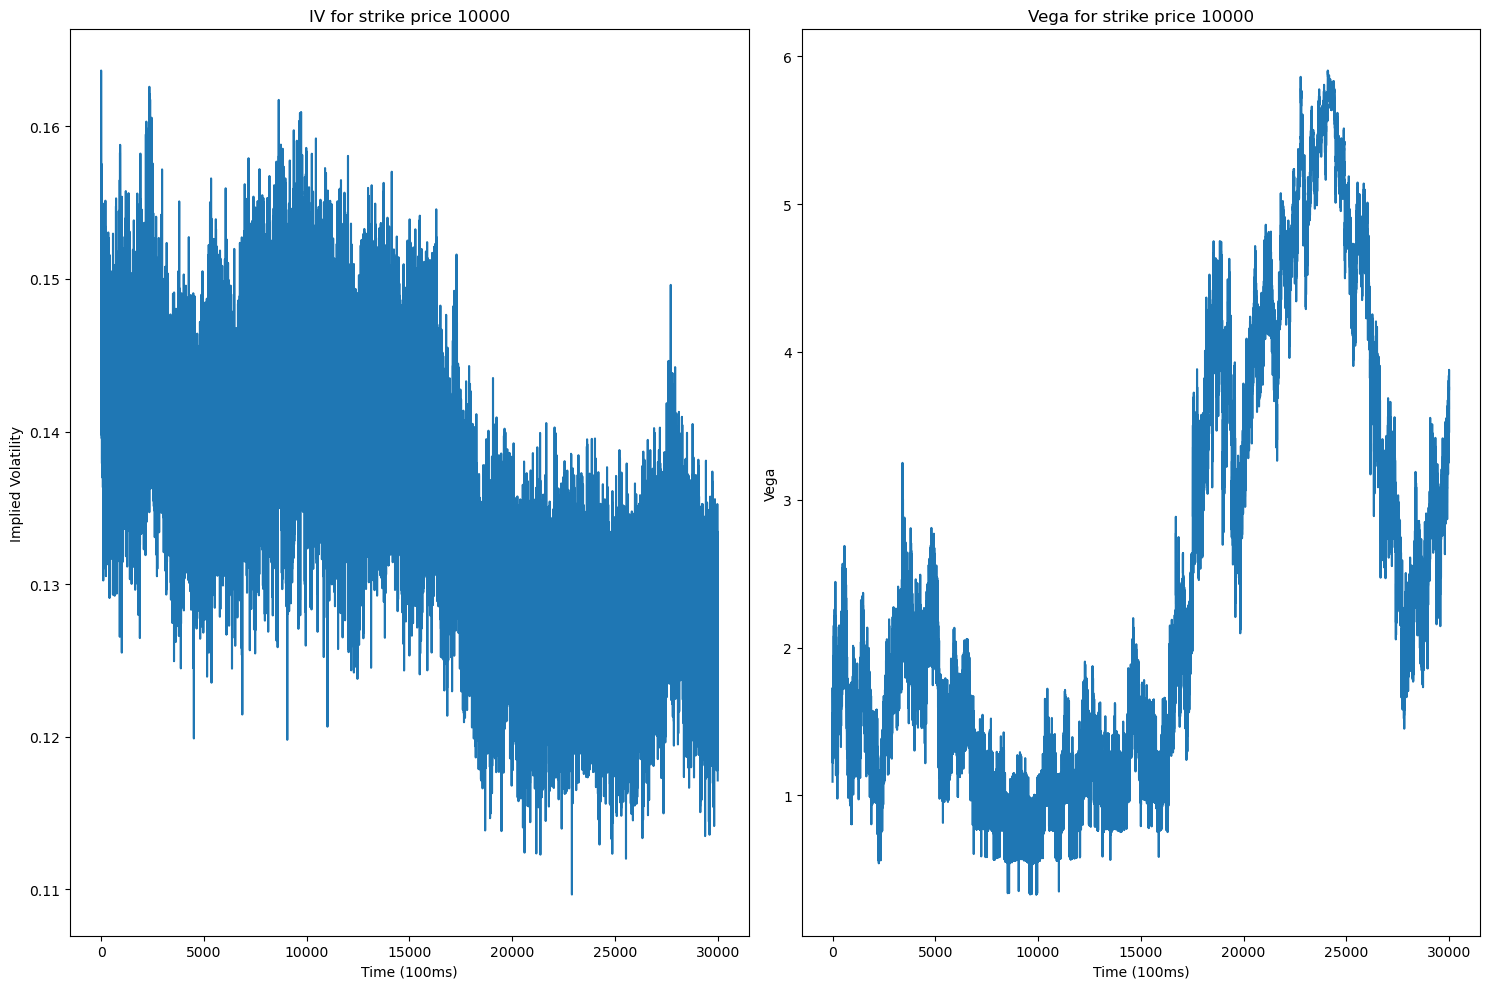

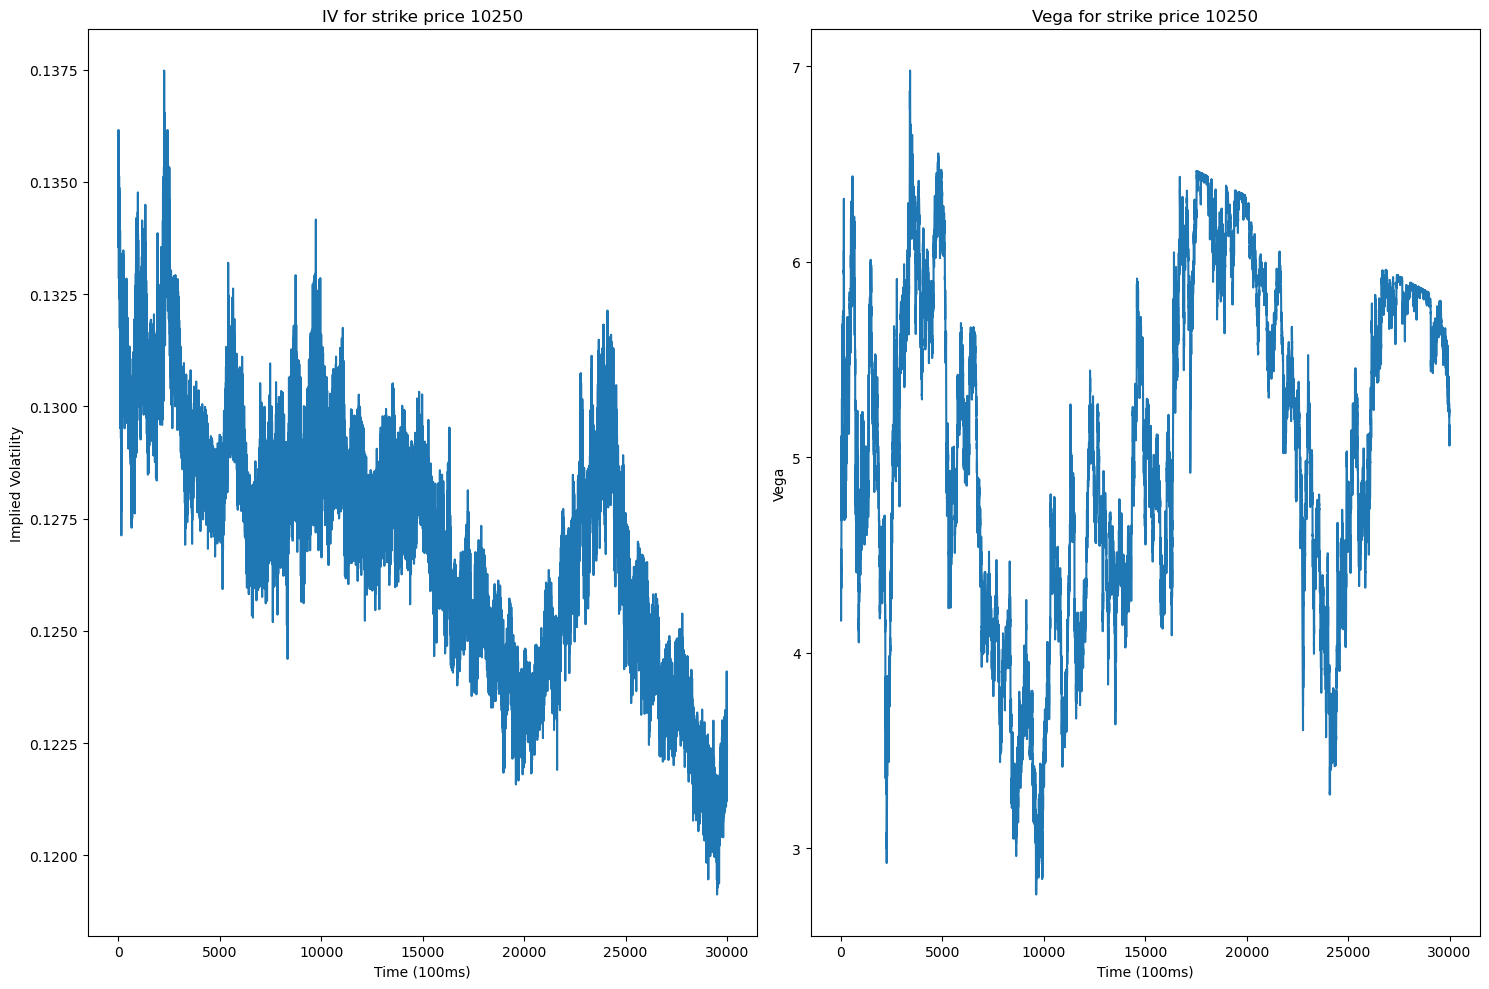

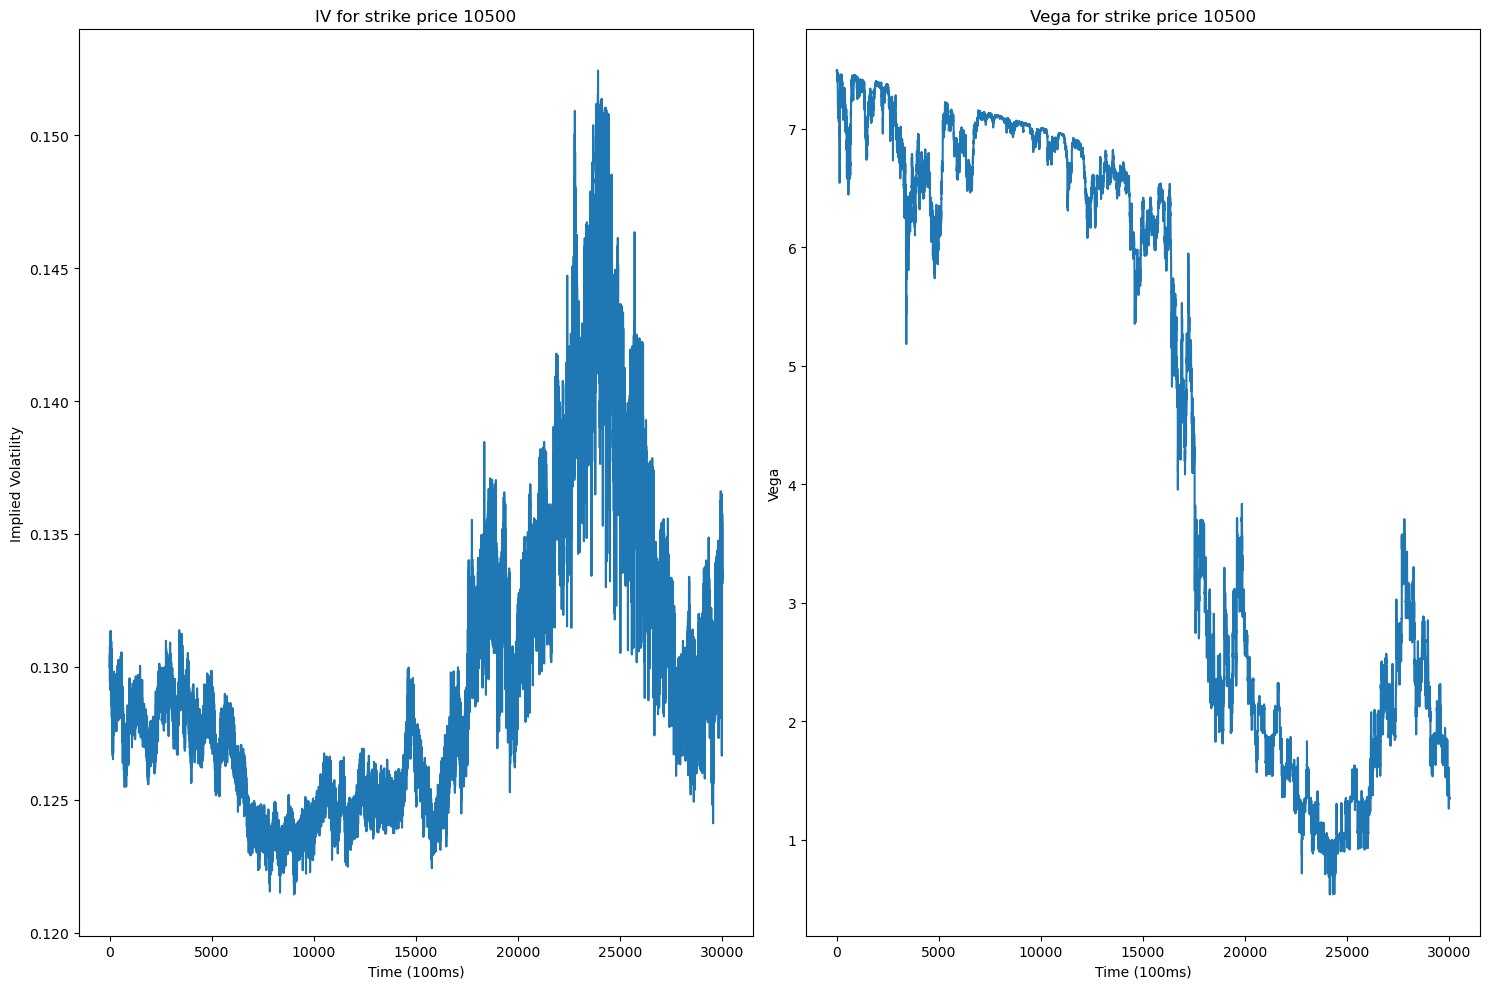

In [46]:
for strike in STRIKES:
    option = pd.read_csv(f"./option_data/VOLCANIC_ROCK_VOUCHER_{strike}.csv", sep=';')
    fig, ax = plt.subplots(1, 2, figsize=(15, 10))
    ax[0].plot(option['implied_volatility'].replace(0, np.nan).ffill())
    ax[0].set_title("IV for strike price " + str(strike))
    ax[0].set_xlabel("Time (100ms)")
    ax[0].set_ylabel("Implied Volatility")

    ax[1].plot(option['vega'])
    ax[1].set_title("Vega for strike price " + str(strike))
    ax[1].set_xlabel("Time (100ms)")
    ax[1].set_ylabel("Vega")
    plt.tight_layout()
    plt.plot()

The IV is no-longer mean-reversion. Then try fit the smile curve with different strikes.

In [47]:
strike = STRIKES[0]
df_smile = pd.read_csv(f"./option_data/VOLCANIC_ROCK_VOUCHER_{strike}.csv", sep=';', usecols=['implied_volatility'])
df_smile.rename({'implied_volatility': 'IV_' + str(strike)}, axis=1, inplace=True)
df_smile['spot_price'] = spot['mid_price']
df_smile['tte'] = (TIME_TO_MATURITY - spot['day'] - spot['timestamp'] / 1000000) / 250
df_smile['m_'+ str(strike)] = (np.log(strike) - np.log(df_smile['spot_price'])) / np.sqrt(df_smile['tte'])
for strike in STRIKES[1:]:
    df_smile['IV_'+str(strike)] = pd.read_csv(f"./option_data/VOLCANIC_ROCK_VOUCHER_{strike}.csv", sep=';', usecols=['implied_volatility'])['implied_volatility']
    df_smile['m_'+ str(strike)] = (np.log(strike) - np.log(df_smile['spot_price'])) / np.sqrt(df_smile['tte'])

In [48]:
df_smile.to_csv('./option_data/IV_curve.csv', sep=';', index=False)

In [49]:
df_smile

,IV_9500,spot_price,tte,m_9500,IV_9750,m_9750,IV_10000,m_10000,IV_10250,m_10250,IV_10500,m_10500
0,0.213028,10503.0,0.032000,-0.561081,0.186255,-0.415873,0.140678,-0.274342,0.135015,-0.136306,0.130758,-0.001597
1,0.214287,10510.0,0.032000,-0.564809,0.187690,-0.419600,0.163655,-0.278068,0.135135,-0.140032,0.129949,-0.005321
2,0.214826,10513.0,0.031999,-0.566408,0.188305,-0.421198,0.151274,-0.279666,0.136155,-0.141628,0.130524,-0.006917
3,0.215634,10517.5,0.031999,-0.568803,0.179555,-0.423593,0.155980,-0.282060,0.134130,-0.144021,0.130013,-0.009309
4,0.214201,10509.5,0.031998,-0.564553,0.177985,-0.419342,0.146514,-0.277808,0.136116,-0.139768,0.130299,-0.005056
...,...,...,...,...,...,...,...,...,...,...,...,...
29995,0.063437,10168.0,0.020002,-0.480481,0.124490,-0.296816,0.119251,-0.117801,0.121513,0.056793,0.133114,0.227180
29996,0.190464,10167.0,0.020002,-0.479791,0.144322,-0.296124,0.127099,-0.117107,0.122139,0.057489,0.133445,0.227878
29997,0.190466,10167.0,0.020001,-0.479796,0.144323,-0.296127,0.121622,-0.117108,0.122140,0.057490,0.133447,0.227880
29998,0.063437,10167.5,0.020001,-0.480148,0.136181,-0.296477,0.128677,-0.117457,0.121829,0.057143,0.133283,0.227535


There is abnormal iv in deep ITM option (9500 and 9750). Here I look into it to identify extremely small iv.

In [50]:
df_option = pd.read_csv("./option_data/VOLCANIC_ROCK_VOUCHER_9500.csv", sep=';')
df_option.loc[df_smile['IV_9500'] < 0.07]['mid_price'].head(10)
df_merge = pd.concat([df_option[['day', 'timestamp','mid_price', 'delta', 'vega']], df_smile[['spot_price', 'IV_9500', 'm_9500']]], axis=1)
df_merge[:50]

,day,timestamp,mid_price,delta,vega,spot_price,IV_9500,m_9500
0,0,0,1003.5,0.996010,2.221036e-01,10503.0,0.213028,-0.561081
1,0,100,1010.5,0.996034,2.210498e-01,10510.0,0.214287,-0.564809
2,0,200,1013.5,0.996044,2.205983e-01,10513.0,0.214826,-0.566408
3,0,300,1018.0,0.996059,2.199278e-01,10517.5,0.215634,-0.568803
4,0,400,1010.0,0.996032,2.211203e-01,10509.5,0.214201,-0.564553
5,0,500,1006.5,0.996020,2.216458e-01,10506.0,0.213574,-0.562695
6,0,600,1004.5,0.993011,3.656045e-01,10503.5,0.230328,-0.561368
7,0,700,1003.5,0.996010,2.220954e-01,10503.0,0.213038,-0.561105
8,0,800,997.5,1.000000,1.099455e-16,10497.5,0.063437,-0.558180
9,0,900,995.5,1.000000,1.273585e-16,10495.5,0.063437,-0.557119


In [51]:
st = 10510
sigma = 0.15
timestamp = 1300
day = 0
BlackScholes.black_scholes_call(
    st,
    9500,
    (8 - day - timestamp / 1000000) / 250,
    sigma
)

1010.0052777870751

Vega is important. When the strik is far away from the spot price, the vega can be very small ~0.2, suggesting 1% change in IV only leads to the price change of 0.2. In general, the deviation of base IV is on the order of 1%, therefore we expect vega significantly higher than 1 to gain profit purely from vol.

In [52]:
def parabolic_fit(row, strikes = STRIKES):
    mask = (row[[f"IV_{strike}" for strike in strikes]] > 0.1).values
    filtered_strikes = [strike for strike, m in zip(strikes, mask) if m]
    x = np.power(row[[f"m_{strike}" for strike in filtered_strikes]].values, 2)
    y = row[[f"IV_{strike}" for strike in filtered_strikes]].values
    cov = np.cov(x, y)
    coef = cov[0][1] / cov[0][0]
    intercept = np.mean(y) - np.mean(x) * coef
    return coef, intercept

# def parabolic_fit(row, strikes=STRIKES):
#     mask = (row[[f"IV_{strike}" for strike in strikes]] > 0.08).values
#     filtered_strikes = [strike for strike, m in zip(strikes, mask) if m]
#     if len(filtered_strikes) < 3:
#         return [np.nan, np.nan, np.nan]
#     x = row[[f"m_{strike}" for strike in filtered_strikes]].values
#     y = row[[f"IV_{strike}" for strike in filtered_strikes]].values
#     coef_ = np.polyfit(x, y, 2)
#     return coef_.tolist()

df_smile['parabolic_coef'] = df_smile.apply(parabolic_fit, axis=1)
df_smile['IV_ATM'] = df_smile['parabolic_coef'].apply(lambda x: x[1])
# df_smile['linear_coef'] = df_smile['parabolic_coef'].apply(lambda x: x[1])
df_smile['parabolic_coef'] = df_smile['parabolic_coef'].apply(lambda x: x[0])

<Axes: >

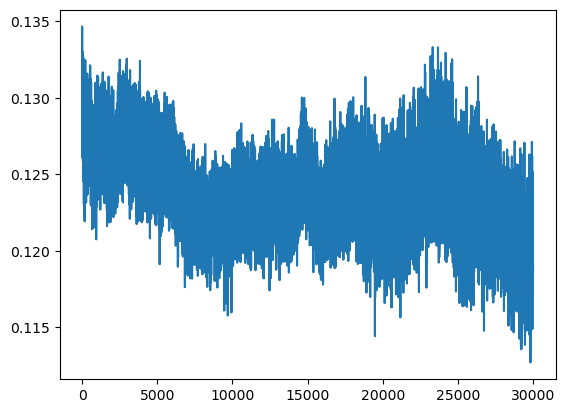

In [53]:
df_smile['IV_ATM'].plot()

<Axes: >

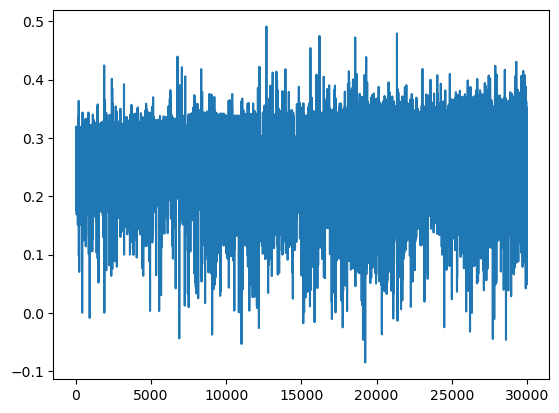

In [54]:
df_smile['parabolic_coef'].plot()

In [55]:
df_smile.to_csv("./option_data/IV_curve.csv", sep=';', index=False)

Verify result

In [56]:
idx = 2046
strike = 9500
day = 1
df = pd.read_csv(f"./round-3-island-data-bottle/prices_round_3_day_{day}.csv", sep=';')
spot = df[(df['product'] == 'VOLCANIC_ROCK') & (df['day'] == day)].copy().reset_index(drop=True)
option =  df[(df['product'] == f'VOLCANIC_ROCK_VOUCHER_{strike}') & (df['day'] == day)].copy().reset_index(drop=True)
call_price = option.loc[option['day'] == day, 'mid_price'].reset_index(drop=True).iloc[idx]
spot = spot.loc[spot['day'] == day, 'mid_price'].reset_index(drop=True).iloc[idx]
time_to_maturity = (TIME_TO_MATURITY - day - option['timestamp'].iloc[idx] / 1000000) / 250

iv = BlackScholes.implied_volatility(call_price, spot, strike, time_to_maturity)
print(f'Theoretical: {iv}')
df = pd.read_csv(f"./option_data/VOLCANIC_ROCK_VOUCHER_{strike}.csv", sep=';')
print(f'Practical: {df.loc[df['day'] == day, 'implied_volatility'].reset_index(drop=True).iloc[idx]}')

Theoretical: 0.2232144680023193
Practical: 0.2232144680023193


Time series analysis of base IV.

In [57]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

# adf test
adf_test = adfuller(df_smile['IV_ATM'])
print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")


ADF Statistic: -4.246772889119331
p-value: 0.0005485494082572259


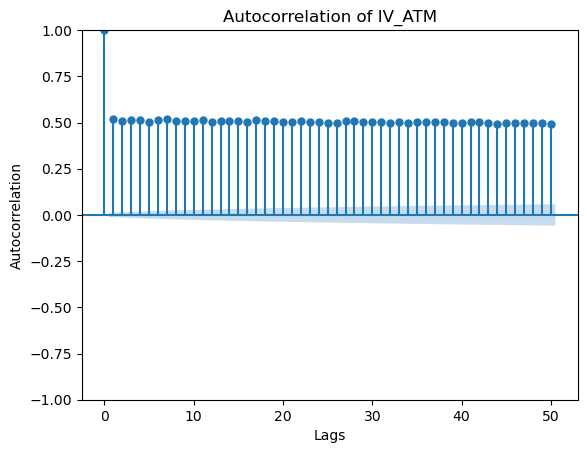

In [58]:
# Plot the autocorrelation of df_smile['IV_ATM']
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

plot_acf(df_smile['IV_ATM'], lags=50)
plt.title('Autocorrelation of IV_ATM')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

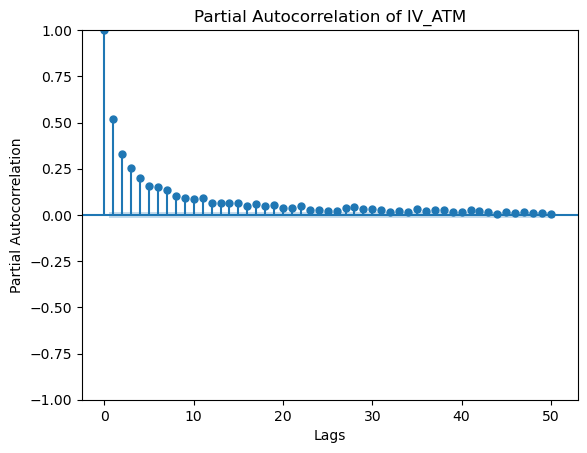

In [59]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(df_smile['IV_ATM'], lags=50, alpha=0.01)  
plt.title('Partial Autocorrelation of IV_ATM')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.show()

First order difference

In [60]:
df_smile['IV_ATM_DIFF'] = df_smile['IV_ATM'].diff()

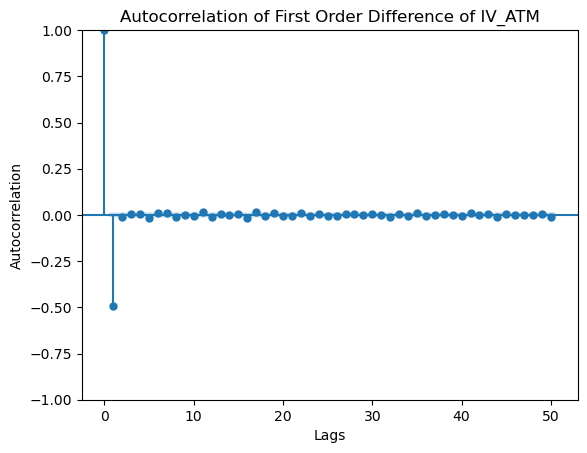

In [61]:
plot_acf(df_smile['IV_ATM_DIFF'].dropna(), lags=50)
plt.title('Autocorrelation of First Order Difference of IV_ATM')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

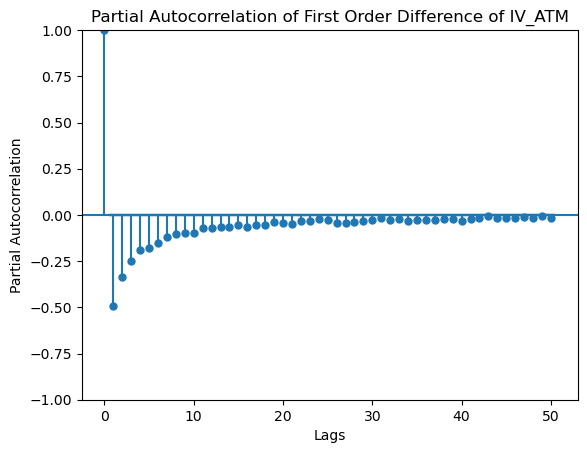

In [62]:
plot_pacf(df_smile['IV_ATM_DIFF'].dropna(), lags=50)
plt.title('Partial Autocorrelation of First Order Difference of IV_ATM')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.show()

Strong mean-reversion suggested by ~-0.5 autocorrelation of order 1.

In [63]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Regress df_smile['IV_ATM_DIFF'] on its lagged values
X = df_smile['IV_ATM_DIFF'].shift(1).dropna()
y = df_smile['IV_ATM_DIFF'].dropna()[1:]  # Drop the first value to align with X

# Train-test split
train_size = int(len(X) * 0.8)

model = LinearRegression()
model.fit(X.values[:train_size].reshape(-1, 1), y.values[:train_size].reshape(-1, 1))
print(model.coef_, model.intercept_)

[[-0.49256801]] [-4.44539466e-07]


In [64]:
print(r2_score(y[train_size:], model.predict(X.values[train_size:].reshape(-1, 1))))

0.23701429746962532


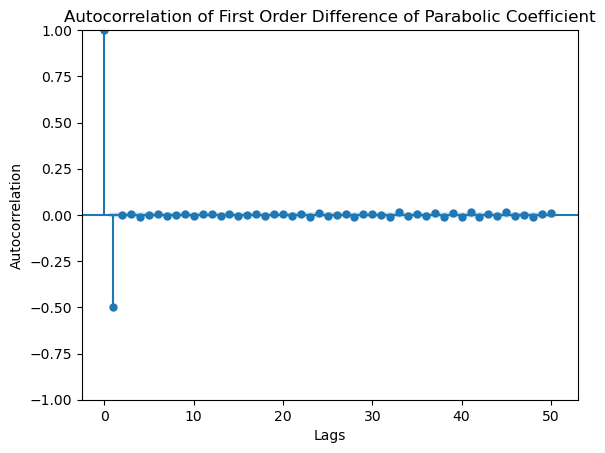

In [65]:
plot_acf(df_smile['parabolic_coef'].diff().dropna(), lags=50)
plt.title('Autocorrelation of First Order Difference of Parabolic Coefficient')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

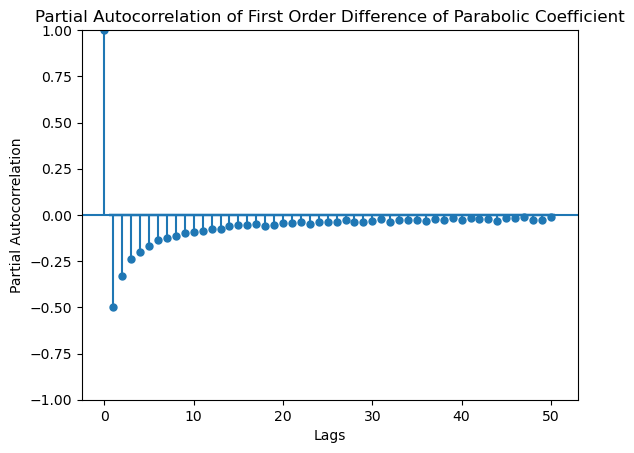

In [66]:
plot_pacf(df_smile['parabolic_coef'].diff().dropna(), lags=50)
plt.title('Partial Autocorrelation of First Order Difference of Parabolic Coefficient')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.show()

In [67]:
X = df_smile['parabolic_coef'].diff().shift(1).dropna()
y = df_smile['parabolic_coef'].diff().dropna()[1:]  # Drop the first value to align with X

# Train-test split
train_size = int(len(X) * 0.8)

model = LinearRegression()
model.fit(X.values[:train_size].reshape(-1, 1), y.values[:train_size].reshape(-1, 1))
print(model.coef_, model.intercept_)

[[-0.49404274]] [-2.02646744e-06]


In [68]:
print(r2_score(y[train_size:], model.predict(X.values[train_size:].reshape(-1, 1))))

0.2514671575305152


Predict the price of options

In [69]:
spot = pd.read_csv("./option_data/VOLCANIC_ROCK.csv", sep=';')
option_prices = dict()
for strike in STRIKES:
    option_prices[strike] = (pd.read_csv(f"./option_data/VOLCANIC_ROCK_VOUCHER_{strike}.csv", sep=';')['mid_price'].values)
spot_price = spot['mid_price'].values
tte = (TIME_TO_MATURITY - spot['day'].values - spot['timestamp'].values / 1000000) / 250

In [70]:
iv_curve = pd.read_csv("./option_data/IV_curve.csv", sep=';')
coef = iv_curve['parabolic_coef'].copy()
base_iv = iv_curve['IV_ATM'].copy()

In [71]:
strike = 10500
base_iv_diff = base_iv.diff()
coef_diff = coef.diff()

predicted_base_iv = -0.5 * base_iv_diff + base_iv
predicted_coef = -0.5 * coef_diff + coef

tte -= 1 / 2500000
x2 = np.log(strike / spot_price) ** 2 / tte
predicted_iv = predicted_base_iv + predicted_coef * x2
d1 = (np.log(spot_price / strike) + 0.5 * np.power(predicted_iv, 2) * tte) / predicted_iv / np.sqrt(tte)
d2 = d1 - predicted_iv * np.sqrt(tte)
predicted_price = np.array([spot_price[i] * NormalDist().cdf(x1) - strike * NormalDist().cdf(x2) for i, (x1, x2) in enumerate(zip(d1.values, d2.values))])

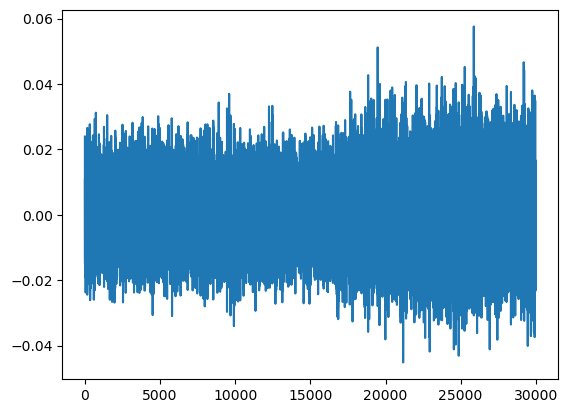

In [72]:
plt.plot(predicted_base_iv[1:-1] / base_iv[2:] - 1, label='Prediction Error')
plt.show()

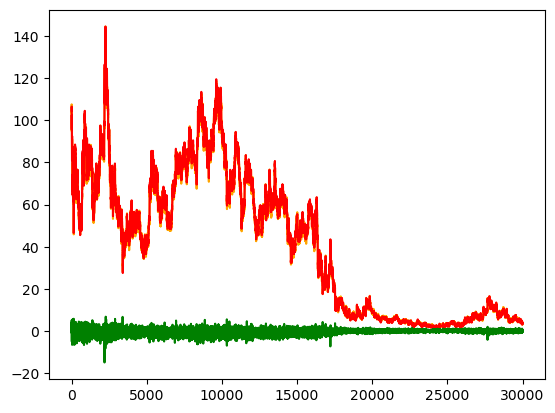

In [73]:
plt.plot(predicted_price[1:-1], label='Predicted Price', color='orange')
plt.plot(option_prices[strike][2:], label='Actual Price', color='red')
plt.plot(predicted_price[1:-1] - option_prices[strike][2:], label='Prediction Error', color='green')
plt.show()

The price itself is hard to predict. We try using the arbitrage opinion. First try to find out the trend term in base iv. Then set threshold for volatility mean-reversion.

In [74]:
np.corrcoef(np.arange(len(df_smile)), df_smile['IV_ATM'].values)[0][1]

-0.4366726101662296

In [75]:
np.corrcoef(np.arange(len(df_smile)), df_smile['parabolic_coef'].values)[0][1]

-0.007951810244264577

In [76]:
model = LinearRegression()
x = np.arange(len(df_smile))
y = df_smile['IV_ATM'].values
# Filter out extreme values
mask = (y > 0.113)
x_filtered = x[mask].reshape(-1, 1)
y_filtered = y[mask].reshape(-1, 1)
model.fit(x_filtered, y_filtered)
print(model.coef_[0], model.intercept_)
print(r2_score(df_smile['IV_ATM'].values, model.predict(np.arange(len(df_smile)).reshape(-1, 1))))

[-1.33074333e-07] [0.12599658]
0.19068291409929627


In [77]:
coef_model = LinearRegression()
x = np.arange(len(df_smile))
y = df_smile['parabolic_coef'].values
coef_model.fit(x.reshape(-1, 1), y.reshape(-1, 1))
print(coef_model.coef_[0], coef_model.intercept_)
print(r2_score(df_smile['parabolic_coef'].values, coef_model.predict(np.arange(len(df_smile)).reshape(-1, 1))))

[-4.55616248e-08] [0.2647216]
6.323128616092522e-05


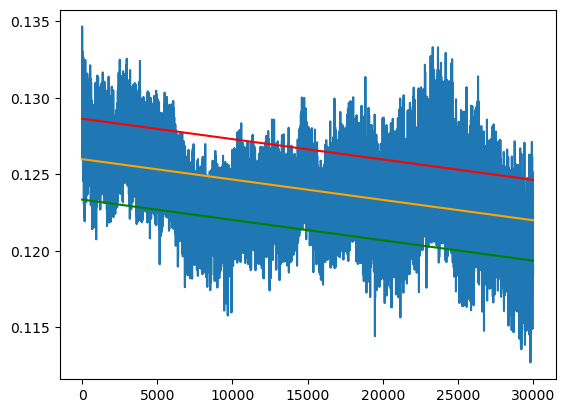

In [78]:
thres = 1
theo = np.arange(len(df_smile)) * model.coef_[0] + model.intercept_
upper = theo + thres * np.std(df_smile['IV_ATM'].values)
lower = theo - thres * np.std(df_smile['IV_ATM'].values)

# plot
plt.plot(df_smile['IV_ATM'].values, label='IV_ATM')
plt.plot(theo, label='Theoretical IV', color='orange')
plt.plot(upper, label='Upper Bound', color='red')
plt.plot(lower, label='Lower Bound', color='green')

In [79]:
np.std(df_smile['IV_ATM'].values)

0.002640397220890173

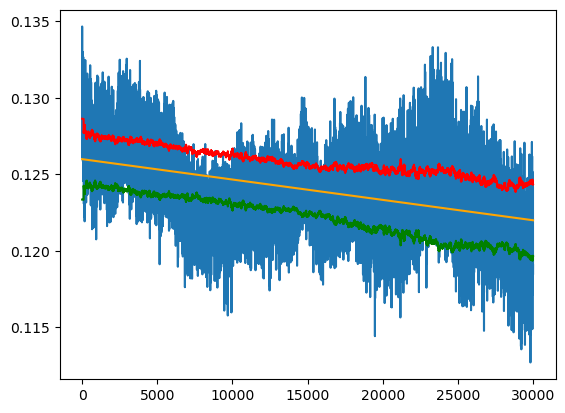

In [80]:
thres = 1
window = 100
# theo = df_smile['IV_ATM'].rolling(window=window, min_periods=1).mean()
theo = np.arange(len(df_smile)) * model.coef_[0] + model.intercept_
rolling_std = df_smile['IV_ATM'].rolling(window=window).std()
rolling_std = rolling_std.fillna(np.std(df_smile['IV_ATM'].values))
upper = np.arange(len(df_smile)) * model.coef_[0][0] + model.intercept_[0] + thres * rolling_std
lower = np.arange(len(df_smile)) * model.coef_[0][0] + model.intercept_[0] - thres * rolling_std

# plot
plt.plot(df_smile['IV_ATM'].values, label='IV_ATM')
plt.plot(theo, label='Theoretical IV', color='orange')
plt.plot(upper, label='Upper Bound', color='red')
plt.plot(lower, label='Lower Bound', color='green')

Calculate the theoretical IV for single options

In [81]:
theo = np.arange(len(df_smile)) * model.coef_[0] + model.intercept_
parabolic_coef = df_smile['parabolic_coef'].mean()
print(f"parabolic_coef: {parabolic_coef}")
theo_iv_per_option = dict()
for strike in STRIKES:
    x2 = np.log(strike / spot_price) ** 2 / tte
    theo_iv_per_option[strike] = x2 * parabolic_coef + theo

parabolic_coef: 0.2640381967784543


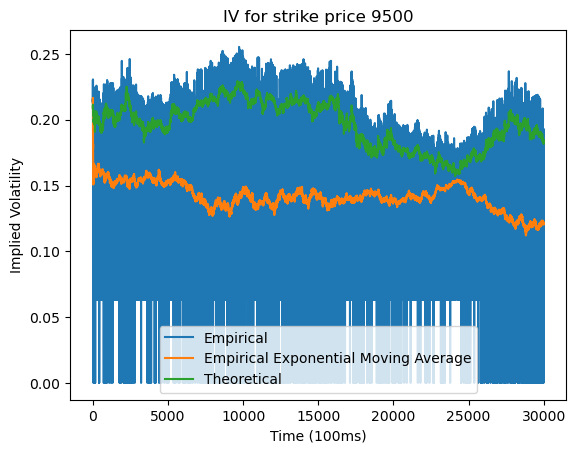

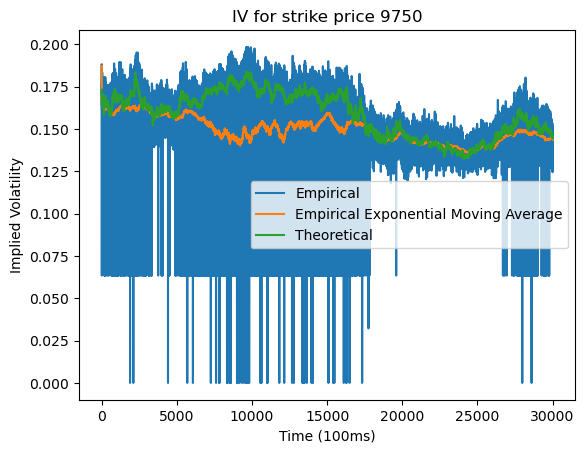

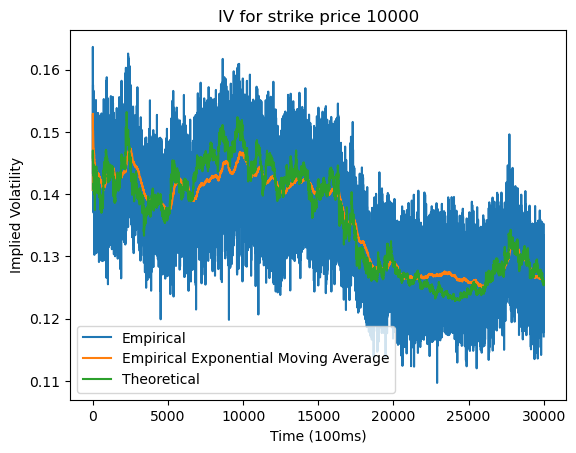

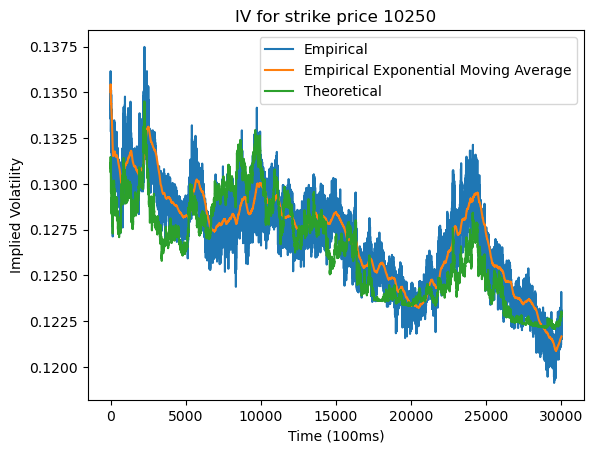

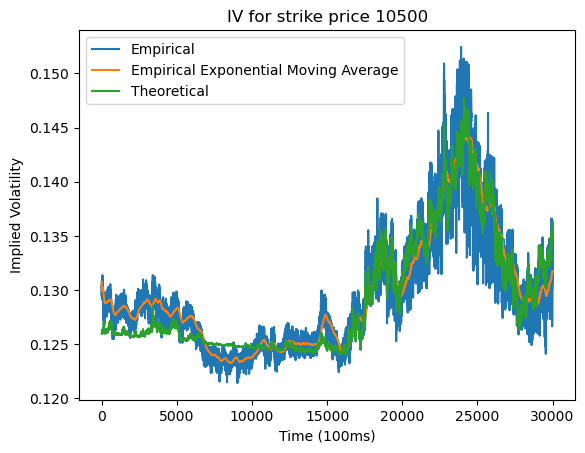

In [82]:
for strike in STRIKES:
    option = pd.read_csv(f"./option_data/VOLCANIC_ROCK_VOUCHER_{strike}.csv", sep=';')
    fig, ax = plt.subplots()
    ax.plot(option['implied_volatility'], label = "Empirical")
    ax.plot(option['implied_volatility'].ewm(span=500).mean(), label="Empirical Exponential Moving Average")
    ax.plot(theo_iv_per_option[strike], label="Theoretical")
    ax.legend()
    ax.set_title("IV for strike price " + str(strike))
    ax.set_xlabel("Time (100ms)")
    ax.set_ylabel("Implied Volatility")
    
    plt.show()

Use simultaneous coefficient instead

In [83]:
theo = np.arange(len(df_smile)) * model.coef_[0] + model.intercept_
theo_iv_per_option = dict()
for strike in STRIKES:
    x = np.log(strike / spot_price) ** 2 / tte
    theo_iv_per_option[strike] = x2 * df_smile['parabolic_coef'].values + theo

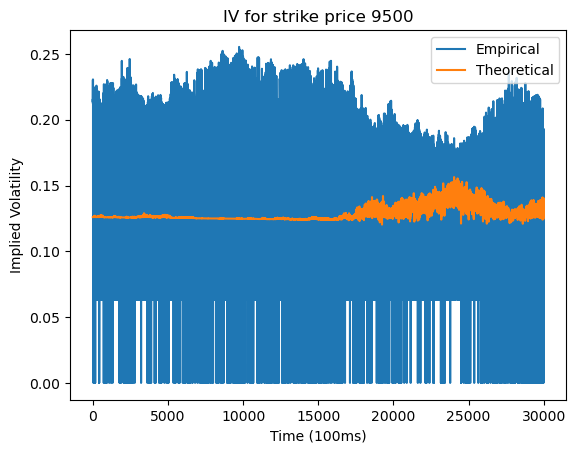

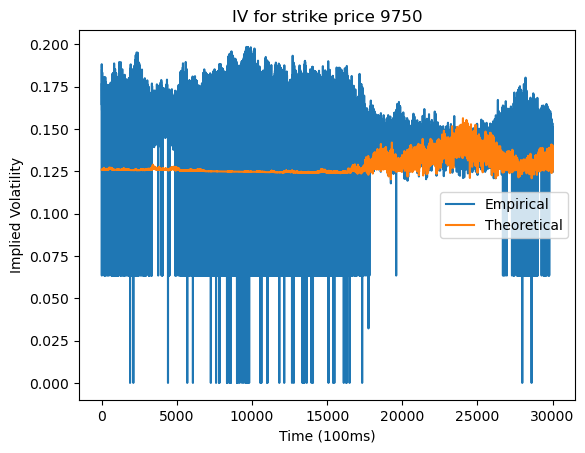

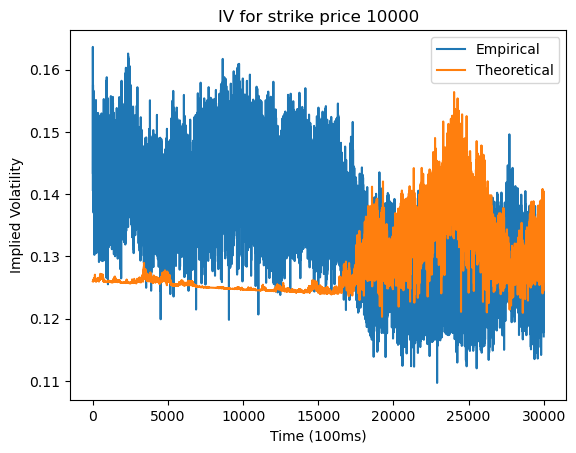

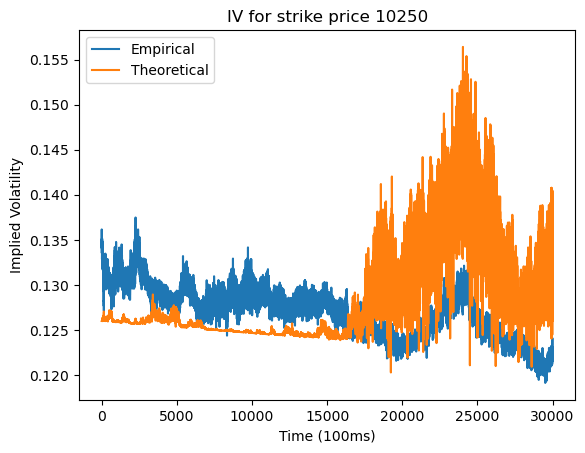

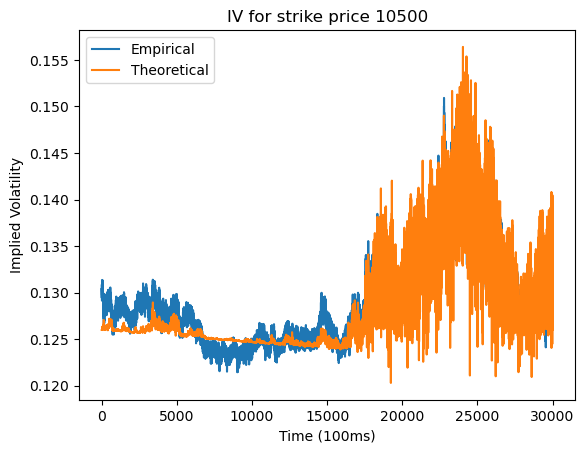

In [84]:
for strike in STRIKES:
    option = pd.read_csv(f"./option_data/VOLCANIC_ROCK_VOUCHER_{strike}.csv", sep=';')
    fig, ax = plt.subplots()
    ax.plot(option['implied_volatility'], label = "Empirical")
    ax.plot(theo_iv_per_option[strike], label="Theoretical")
    ax.legend()
    ax.set_title("IV for strike price " + str(strike))
    ax.set_xlabel("Time (100ms)")
    ax.set_ylabel("Implied Volatility")
    
    plt.show()

Try using linearly parabolic curve

In [85]:
theo = np.arange(len(df_smile)) * model.coef_[0] + model.intercept_
parabolic_coef = np.arange(len(df_smile)) * coef_model.coef_[0] + coef_model.intercept_
theo_iv_per_option = dict()
for strike in STRIKES:
    x = np.log(strike / spot_price) ** 2 / tte
    theo_iv_per_option[strike] = x2 * parabolic_coef + theo

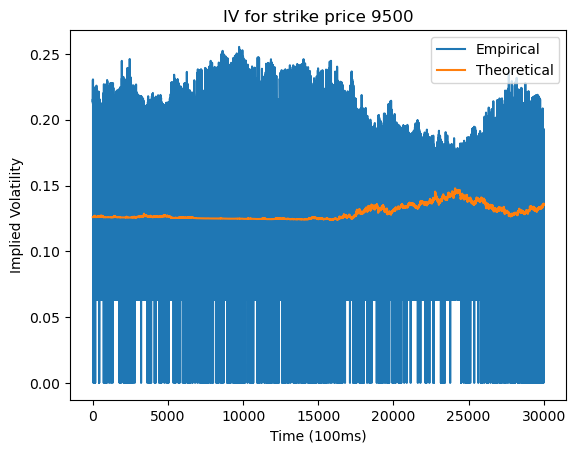

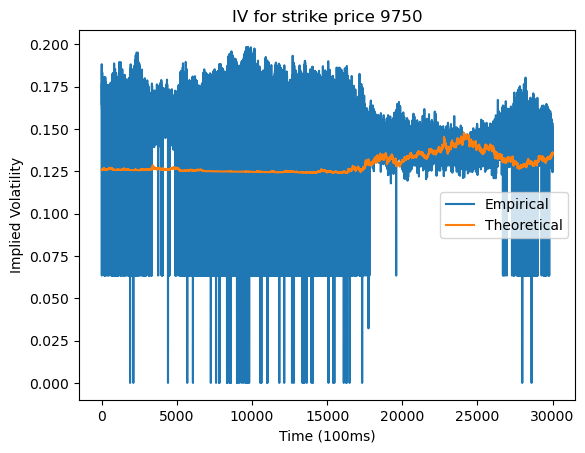

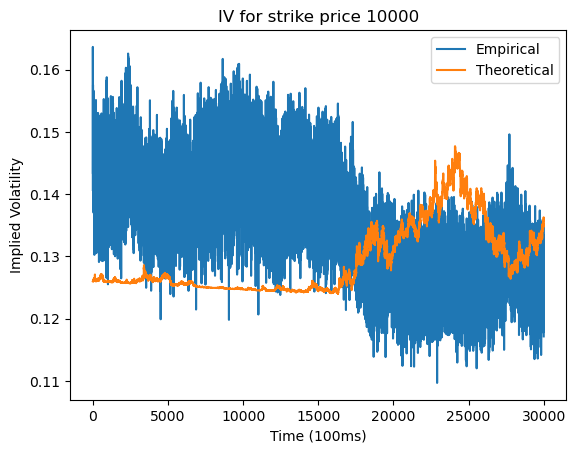

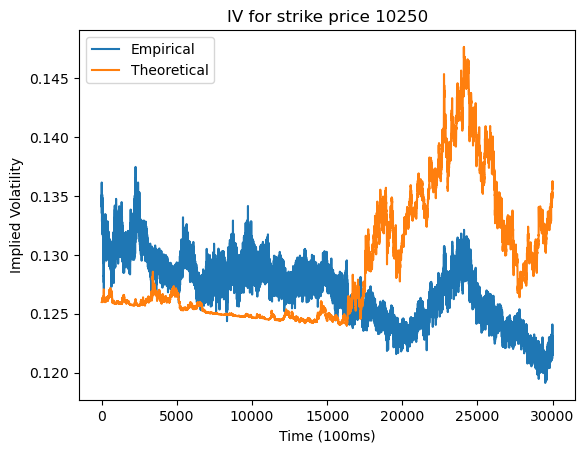

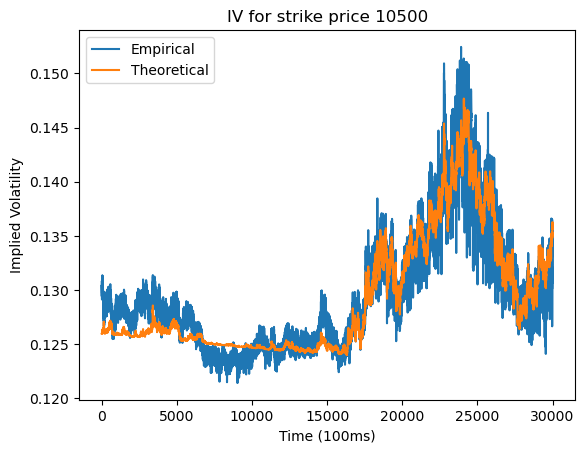

In [86]:
for strike in STRIKES:
    option = pd.read_csv(f"./option_data/VOLCANIC_ROCK_VOUCHER_{strike}.csv", sep=';')
    fig, ax = plt.subplots()
    ax.plot(option['implied_volatility'], label = "Empirical")
    ax.plot(theo_iv_per_option[strike], label="Theoretical")
    ax.legend()
    ax.set_title("IV for strike price " + str(strike))
    ax.set_xlabel("Time (100ms)")
    ax.set_ylabel("Implied Volatility")
    
    plt.show()

Cannot obatain the fair value of IV for 10250 and 10500 because of the error in parabolic curve. The 10250 and 10500 is close to the spot price, leading to higher volatilities in IV.

In [87]:
np.std(spot['mid_price'].pct_change()) / np.sqrt(3 / 250)

0.002284842576189261

In [133]:
option = pd.read_csv("./option_data/VOLCANIC_ROCK_VOUCHER_10000.csv", sep=';')
spot = pd.read_csv("./option_data/VOLCANIC_ROCK.csv", sep=';')
option.head()

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,...,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss,implied_volatility,delta,gamma,vega
0,0,0,VOLCANIC_ROCK_VOUCHER_10000,505.0,19.0,NaN,NaN,NaN,NaN,506,...,NaN,NaN,NaN,NaN,505.5,0.0,0.140678,0.975161,0.000220,1.092140
1,0,100,VOLCANIC_ROCK_VOUCHER_10000,515.0,13.0,NaN,NaN,NaN,NaN,516,...,NaN,NaN,NaN,NaN,515.5,0.0,0.163655,0.956713,0.000299,1.727162
2,0,200,VOLCANIC_ROCK_VOUCHER_10000,516.0,15.0,NaN,NaN,NaN,NaN,517,...,NaN,NaN,NaN,NaN,516.5,0.0,0.151274,0.968717,0.000248,1.324735
3,0,300,VOLCANIC_ROCK_VOUCHER_10000,521.0,13.0,NaN,NaN,NaN,NaN,522,...,NaN,NaN,NaN,NaN,521.5,0.0,0.155980,0.965792,0.000258,1.426671
4,0,400,VOLCANIC_ROCK_VOUCHER_10000,512.0,15.0,NaN,NaN,NaN,NaN,513,...,NaN,NaN,NaN,NaN,512.5,0.0,0.146514,0.971883,0.000234,1.212076


In [134]:
tte = (TIME_TO_MATURITY - option['day'] - option['timestamp'] / 1000000) / 250

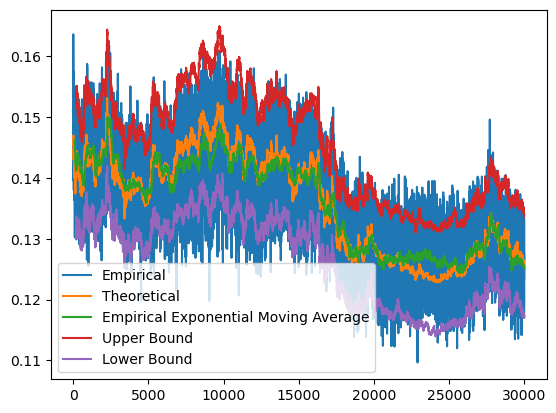

In [152]:
theo = model.coef_[0] * np.arange(len(option)) + model.intercept_[0]
x2 = np.log(10000 / spot['mid_price'].values) ** 2 / tte
theo += x2 * df_smile['parabolic_coef'].mean()

std = option['implied_volatility'].rolling(window=200).std()
thres = 2

plt.plot(option['implied_volatility'], label = "Empirical")
plt.plot(theo, label="Theoretical")
plt.plot(option['implied_volatility'].rolling(100).mean(), label="Empirical Exponential Moving Average")
plt.plot(theo + std * thres, label="Upper Bound")
plt.plot(theo - std * thres, label="Lower Bound")
plt.legend()
plt.show()

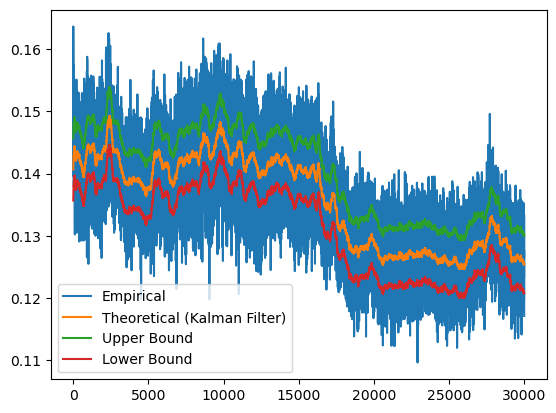

In [153]:
import numpy as np
import matplotlib.pyplot as plt

# 提取观测值
observations = option['implied_volatility'].values

# 初始化卡尔曼滤波器参数
n = len(observations)
state_estimates = np.zeros(n)
state_covariances = np.zeros(n)

# 假设初始状态均值和协方差
state_estimates[0] = observations[0]
state_covariances[0] = 0.000001  # 初始协方差

# 定义过程噪声和测量噪声
process_variance = 1e-8  # 过程噪声方差
measurement_variance = np.var(observations)  # 测量噪声方差

# 卡尔曼滤波器迭代
for t in range(1, n):
    # 预测步骤
    predicted_state = state_estimates[t - 1]
    predicted_covariance = state_covariances[t - 1] + process_variance

    # 更新步骤
    kalman_gain = predicted_covariance / (predicted_covariance + measurement_variance)
    state_estimates[t] = predicted_state + kalman_gain * (observations[t] - predicted_state)
    state_covariances[t] = (1 - kalman_gain) * predicted_covariance

# 计算 theo 和 std
theo = pd.Series(state_estimates, index=option.index)
std = pd.Series(np.sqrt(state_covariances), index=option.index)

# 设置阈值
thres = 5

# 绘图
plt.plot(option['implied_volatility'], label="Empirical")
plt.plot(theo, label="Theoretical (Kalman Filter)")
plt.plot(theo + std * thres, label="Upper Bound")
plt.plot(theo - std * thres, label="Lower Bound")
plt.legend()
plt.show()

<Axes: >

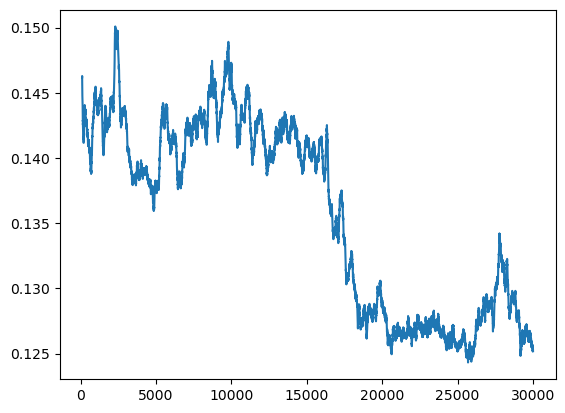

In [137]:
option['implied_volatility'].rolling(window=100).mean().plot()

<Axes: >

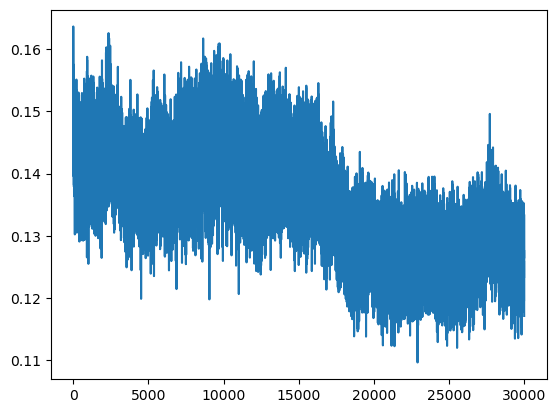

In [138]:
option['implied_volatility'].plot()

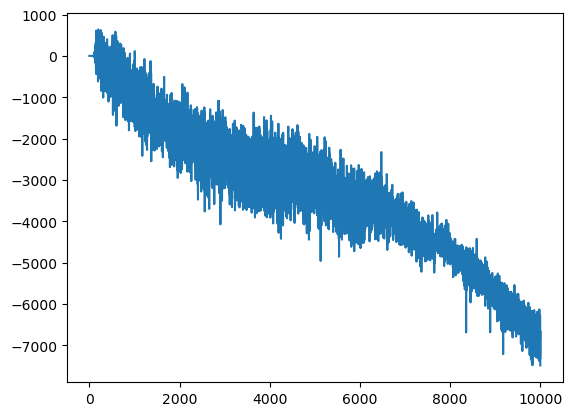

In [186]:
import json
with open("pnl_history_day_2.json", "r") as f:
    pnl_history = json.load(f)
plt.plot(pd.Series(pnl_history['VOLCANIC_ROCK'], dtype=np.float64).ffill().to_numpy() + pd.Series(pnl_history['VOLCANIC_ROCK_VOUCHER_10000'], dtype=np.float64).ffill().to_numpy())